**Part 1. AI Agent 이해와 입문 프로젝트**

- Chapter 03. LangGraph 입문 프로젝트

    - **📒[실습]** Clip 05. 문법 교정과 번역기능이 있는 영어 회화 챗봇 만들기

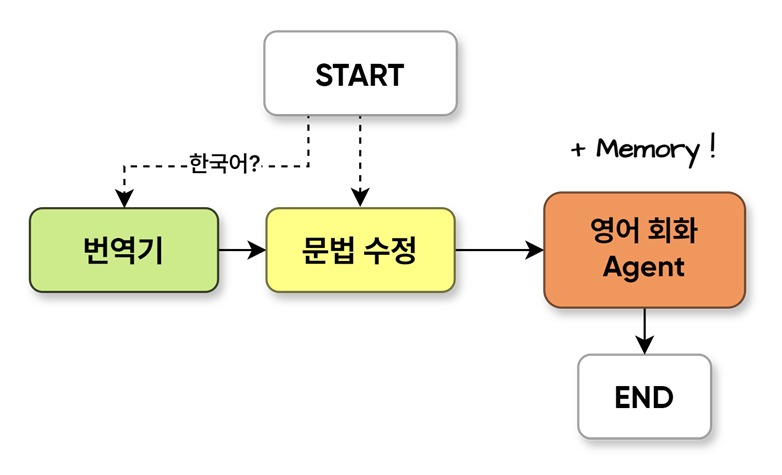

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

### Step 1: 회화 메시지와 문법 교정 이력 등을 관리하기 위해 필요한 State 정의하기

In [2]:
from langgraph.graph import MessagesState, StateGraph

class State(MessagesState):
    is_correct: bool
    corrected_sentence: str
    feedback: str

In [3]:
graph_builder = StateGraph(State)

### Step 2: Node 추가하기 

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

- 번역 기능을 하는 노드

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AIMessage

TRANSLATION_SYSTEM_TEMPLATE = """
You are a helpful assistant that translates Korean conversation messages into English. 
Whenever a Korean message is given, provide its accurate English translation.
Do not wrap the response in any backticks or anything else. Respond with a message only!
"""

TRANSLATION_USER_TEMPLATE = """
Please translate the following Korean message into English:
{messages}
Translation Result:
"""

def translation(state: State):
    translation_msgs = [
        ("system", TRANSLATION_SYSTEM_TEMPLATE),
        ("user", TRANSLATION_USER_TEMPLATE),
    ]
    translation_prompt = ChatPromptTemplate.from_messages(translation_msgs)

    response = llm.invoke(
        translation_prompt.format_messages(
            messages=state["messages"]
        )
    )
    print("\n[translation node]")
    print("translation result:", response.content)
    return {"messages": [AIMessage(content=response.content)]}

graph_builder.add_node("translation", translation)

- 문법 교정 기능을 하는 노드

In [6]:
from pydantic import BaseModel, Field


class GrammarFeedback(BaseModel):
    """Respond to the user with this"""

    corrected_sentence: str = Field(description="The corrected version of the user's sentence.")
    feedback: str = Field(description="An explanation of the grammatical errors and the reason for the correction.")
    is_correct: bool = Field(description="Whether the user's sentence was correct or not.")

In [7]:
GRAMMAR_CORRECTION_SYSTEM_TEMPLATE = """
You are a helpful assistant that corrects grammar in English sentences written by users in casual or conversational contexts.
Only fix clear grammar mistakes that might confuse the listener or sound unnatural in everyday conversation.
Ignore minor issues like informal punctuation (e.g., extra exclamation marks), casual phrasing, or relaxed capitalization, as long as the meaning is clear and the sentence sounds natural in spoken English.
If the sentence is already fine for casual conversation, return it unchanged and leave feedback blank.
"""

GRAMMAR_CORRECTION_USER_TEMPLATE = """
User Input: {messages}
Feedback:
"""

def correction(state: State):
    correction_msgs = [
        ("system", GRAMMAR_CORRECTION_SYSTEM_TEMPLATE),
        ("user", GRAMMAR_CORRECTION_USER_TEMPLATE),
    ]
    correction_prompt = ChatPromptTemplate.from_messages(correction_msgs)

    model_with_structured_output = llm.with_structured_output(GrammarFeedback)

    response = model_with_structured_output.invoke(
        correction_prompt.format_messages(
            messages=state["messages"][-1]
        )
    )
    print("\n[correction node]")
    print("수정 검토 대상 문장: ", state["messages"][-1])
    print("수정 후 문장:", response.corrected_sentence)
    print("피드백 내용: ", response.feedback)
    print("is_correct: ", response.is_correct)


    return {
        "messages": [AIMessage(
            content=response.corrected_sentence,
        )], 
        "corrected_sentence": response.corrected_sentence,
        "feedback": response.feedback,
        "is_correct": bool(response.is_correct)
    }


graph_builder.add_node("correction", correction)

- 피드백을 기반으로 답변하는 노드

In [8]:
CHAT_SYSTEM_TEMPLATE = """
You are an English assistant helping users improve their grammar and conversational skills.
If the CORRECT FLAG is True, it skips without feedback and just follow up with a natural question or comment IN ENGLISH

If the CORRECT FLAG is False, you need to provide feedback on the user's sentence.
Given the corrected sentence and the feedback explanation, first explain why the sentence was corrected in a clear and friendly way IN KOREAN. 
Then, follow up with a natural question or comment IN ENGLISH that encourages the user to continue the conversation.
"""

CHAT_USER_TEMPLATE = """
Corrected Sentence: {corrected_sentence}
Feedback Explanation: {feedback}
CORRECT FLAG: {is_correct}
Answer:
"""


def respond(state: State):
    corrected_sentence = state.get("corrected_sentence", "")
    feedback = state.get("feedback", "")
    is_correct = state.get("is_correct", False)

    print("\n[respond node]")
    chat_msgs = [
        ("system", CHAT_SYSTEM_TEMPLATE),
        ("user", CHAT_USER_TEMPLATE),
    ]
    chat_prompt = ChatPromptTemplate.from_messages(chat_msgs)

    response = llm.invoke(
        chat_prompt.format_messages(
            corrected_sentence=corrected_sentence, feedback=feedback, is_correct=is_correct,
        )
    )
    print("피드백 기반 답변: ", response.content)
    return {"messages": [AIMessage(content=response.content)]}

graph_builder.add_node("respond", respond)


### Step 3: 번역 or 문법 교정 피드백을 위한 조건부 엣지 추가하기

In [9]:
import re

def route_function(state: State):
    messages = state["messages"]
    last_message = messages[-1].content

    # 사용자 입력이 한국어라면 번역 기능으로 라우팅
    if bool(re.search(r"[가-힣]", last_message)):
        return "translation"
    else:
        return "correction" 

In [10]:
from langgraph.graph import START

graph_builder.add_conditional_edges(
    START,
    route_function,
    {
        "translation": "translation",
        "correction": "correction",
    },
)

### Step 4: 엣지 추가 & 그래프 컴파일

In [11]:
from langgraph.graph import END

graph_builder.add_edge("translation", "correction")
graph_builder.add_edge("correction", "respond")
graph_builder.add_edge("respond", END)

In [12]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [13]:
graph = graph_builder.compile(checkpointer=memory)

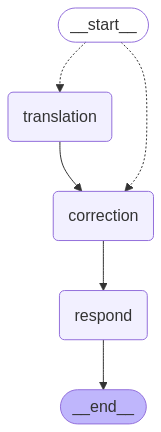

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
config = {"configurable": {"thread_id": "1"}}

In [15]:
while True:
    try:
        user_input = input("User: ")
        print("User:", user_input)
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        response = graph.invoke({
            "messages": [
                {
                    "role": "user",
                    "content": user_input,
                }
            ]
        }, config= config)
        print("Assistant:", response["messages"][-1].content)
    except:
        break

User: Hi, how are you?

[correction node]
수정 검토 대상 문장:  content='Hi, how are you?' additional_kwargs={} response_metadata={} id='86a325c7-db16-40fb-b63a-215f0f8ed97f'
수정 후 문장: Hi, how are you?
피드백 내용:  
is_correct:  True

[respond node]
피드백 기반 답변:  That's a classic and friendly greeting! Have you done anything exciting recently?
Assistant: That's a classic and friendly greeting! Have you done anything exciting recently?
User: I'm prepare a lecture.

[correction node]
수정 검토 대상 문장:  content="I'm prepare a lecture." additional_kwargs={} response_metadata={} id='70341143-8dd2-4fa8-9053-5fda0571dc8c'
수정 후 문장: I'm preparing a lecture.
피드백 내용:  The verb 'prepare' needs to be in the '-ing' form to match the present continuous tense used with 'I'm'.
is_correct:  False

[respond node]
피드백 기반 답변:  "나는 'I am preparing a lecture.'에서 'prepare' 동사를 '-ing' 형태로 사용했습니다. 이는 '나는 강의를 준비하고 있어요.'라는 의미로, 'I'm'처럼 현재 진행형일 때 동사에 '-ing'를 붙여 주어야 해요."

That's interesting! What is the lecture about?
Assistant: "나는 '

In [16]:
response

{'messages': [HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='86a325c7-db16-40fb-b63a-215f0f8ed97f'),
  AIMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='b9b63557-ef54-4ec3-9301-7b35a7184a2b'),
  AIMessage(content="That's a classic and friendly greeting! Have you done anything exciting recently?", additional_kwargs={}, response_metadata={}, id='a230e03f-59dc-4a31-9466-1db07bbee3d0'),
  HumanMessage(content="I'm prepare a lecture.", additional_kwargs={}, response_metadata={}, id='70341143-8dd2-4fa8-9053-5fda0571dc8c'),
  AIMessage(content="I'm preparing a lecture.", additional_kwargs={}, response_metadata={}, id='526f18e5-0fe9-43b9-9903-1b86287c206b'),
  AIMessage(content='"나는 \'I am preparing a lecture.\'에서 \'prepare\' 동사를 \'-ing\' 형태로 사용했습니다. 이는 \'나는 강의를 준비하고 있어요.\'라는 의미로, \'I\'m\'처럼 현재 진행형일 때 동사에 \'-ing\'를 붙여 주어야 해요."\n\nThat\'s interesting! What is the lecture about?', additional_kwargs={}, response_metadat